In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio

from tqdm.notebook import trange, tqdm

In [ ]:
# training parameters
batch_size = 512
dlr = 1e-4
glr = 1e-4

train_epoch = 1

# data_loader
img_size = 32

data_set_root = "../../datasets"

In [ ]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=([0.5]), std=([0.5]))
                                ])

trainset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 80480437.72it/s]


Extracting ../../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 96599436.86it/s]


Extracting ../../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 13475622.10it/s]


Extracting ../../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18424109.06it/s]


Extracting ../../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class Generator(nn.Module):
    def __init__(self, z=64, ch=16):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(z, ch * 4, 4, 1)

        self.conv2 = nn.Conv2d(ch * 4, ch * 4, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(ch * 4)

        self.conv3 = nn.Conv2d(ch * 4, ch * 2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(ch * 2)

        self.conv4 = nn.Conv2d(ch * 2, ch * 2, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(ch * 2)

        self.conv5 = nn.Conv2d(ch * 2, ch * 2, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(ch * 2)

        self.conv_out = nn.Conv2d(ch * 2, 1, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    # Forward method
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.up_nn(F.elu(self.bn1(self.conv2(x))))
        x = self.up_nn(F.elu(self.bn2(self.conv3(x))))
        x = self.up_nn(F.elu(self.bn3(self.conv4(x))))
        x = F.elu(self.bn4(self.conv5(x)))

        return torch.tanh(self.conv_out(x))

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, ch=16):
        super(Discriminator, self).__init__()
        self.conv_in = nn.Conv2d(1, ch, 3, 1, 1)

        self.conv1 = nn.Conv2d(ch, ch*2, 3, 2, 1)
        self.conv2 = nn.Conv2d(ch*2, ch*2, 3, 2, 1)
        self.conv3 = nn.Conv2d(ch*2, ch*4, 3, 2, 1)
        self.conv4 = nn.Conv2d(ch*4, ch*4, 3, 2, 1)
        self.bn = nn.BatchNorm2d(ch*4)

        self.do = nn.Dropout()
        self.conv5 = nn.Conv2d(ch*4, 1, 2, 1)

    # forward method
    def forward(self, x):
        x = F.elu(self.conv_in(x))
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = self.do(F.elu(self.bn(self.conv4(x))))
        x = self.conv5(x).reshape(x.shape[0], 1)
        return x

def gan_bce_loss(output, real_label=True):
    if real_label:
        return F.binary_cross_entropy_with_logits(output, torch.ones_like(output))
    else:
        return F.binary_cross_entropy_with_logits(output, torch.zeros_like(output))

def gan_w_loss(output, real_label=True):
    if real_label:
        return -output.mean()
    else:
        return output.mean()



In [ ]:
# network
latent_noise_dem = 128

g_net = Generator(latent_noise_dem, ch=32).to(device)
d_net = Discriminator(ch=32).to(device)

#A fixed latent noise vector so we can see the improvement over the epochs
fixed_latent_noise = torch.randn(16, latent_noise_dem, 1, 1).to(device)

# Adam optimizer
g_optimizer = optim.Adam(g_net.parameters(), lr=glr)
d_optimizer = optim.Adam(d_net.parameters(), lr=dlr)

# If you are using gradient clipping, initialise the params to be smaller
# with torch.no_grad():
#     for param in d_net.parameters():
#         param.data *= 0.01

test_images_log = []
d_losses = []
g_losses = []

d_out_fake = []
d_out_real = []

g_loss = 0
d_loss = 0



In [ ]:
pbar = trange(train_epoch, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('G Loss: %.4f, D Loss: %.4f' % (g_loss/len(train_loader),
                                                         d_loss/len(train_loader)))
    g_loss = 0
    d_loss = 0

    for num_iter, (images, label) in enumerate(tqdm(train_loader, leave=False)):

#         with torch.no_grad():
#             for param in d_net.parameters():
#                 param.clamp_(-0.05, 0.05)

        images = images.to(device)

        #the size of the current minibatch
        bs = images.shape[0]

        ########### Train Generator G ##############
        #Step1: Sample a latent vector from a normal distribution and pass it through the generator
        #to get a batch of fake images
        latent_noise = torch.randn(bs, latent_noise_dem, 1, 1).to(device)
        g_output = g_net(latent_noise)

        #Step3: Pass the minibatch of fake images (from the Generator) through the Discriminator and calculate
        #the loss against the "real" label - the Generator wants the discriminator to think it's outputs are real
        d_result = d_net(g_output)
        g_train_loss = gan_bce_loss(d_result, True)

        #Step4: Backpropogate the loss through the discriminator and into the Generator and take a training step
        g_net.zero_grad()
        g_train_loss.backward()
        g_optimizer.step()

        #log the generator training loss
        g_losses.append(g_train_loss.item())
        g_loss += g_train_loss.item()

#         with torch.no_grad():
#             for param in g_net.parameters():
#                 param.clamp_(-0.01, 0.01)

        ########### Train Discriminator D! ############

        #Step1: Pass the minibatch of real images through the Discriminator and calculate
        #the loss against the "real" label
        d_real_out = d_net(images)
        d_real_loss = gan_bce_loss(d_real_out, True)
        d_out_real.append(d_real_out.mean().item())

        #Step2: Pass the minibatch of fake images (from the Generator) through the Discriminator and calculate
        #the loss against the "fake" label
        #We "detach()" the output of the Generator here as we don't need it to backpropagate through the
        #Generator in this step
        d_fake_out = d_net(g_output.detach())
        d_fake_loss = gan_bce_loss(d_fake_out, False)
        d_out_fake.append(d_fake_out.mean().item())

        #Step3: Add the two losses together, backpropogate through the discriminator and take a training step
        d_train_loss = (d_real_loss + d_fake_loss)/2

        d_net.zero_grad()
        d_train_loss.backward()
        d_optimizer.step()
        #log the discriminator training loss
        d_losses.append(d_train_loss.item())
        d_loss += d_train_loss.item()

    with torch.no_grad():
        g_net.eval()
        #log the output of the generator given the fixed latent noise vector
        test_fake = g_net(fixed_latent_noise)
        imgs = torchvision.utils.make_grid(test_fake.cpu().detach(), 4, pad_value=1, normalize=True)
        imgs_np = (imgs.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        test_images_log.append(imgs_np)
        g_net.train()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

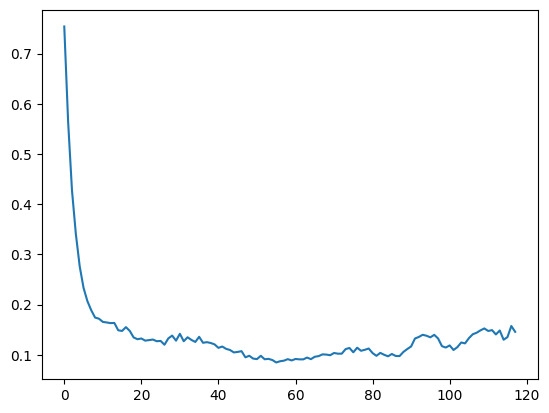

In [ ]:
plt.plot(d_losses)

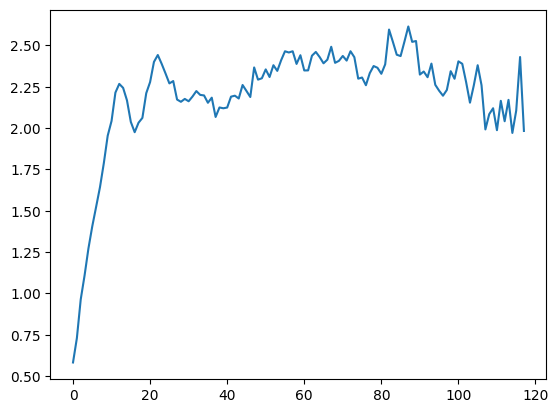

In [ ]:
plt.plot(g_losses)

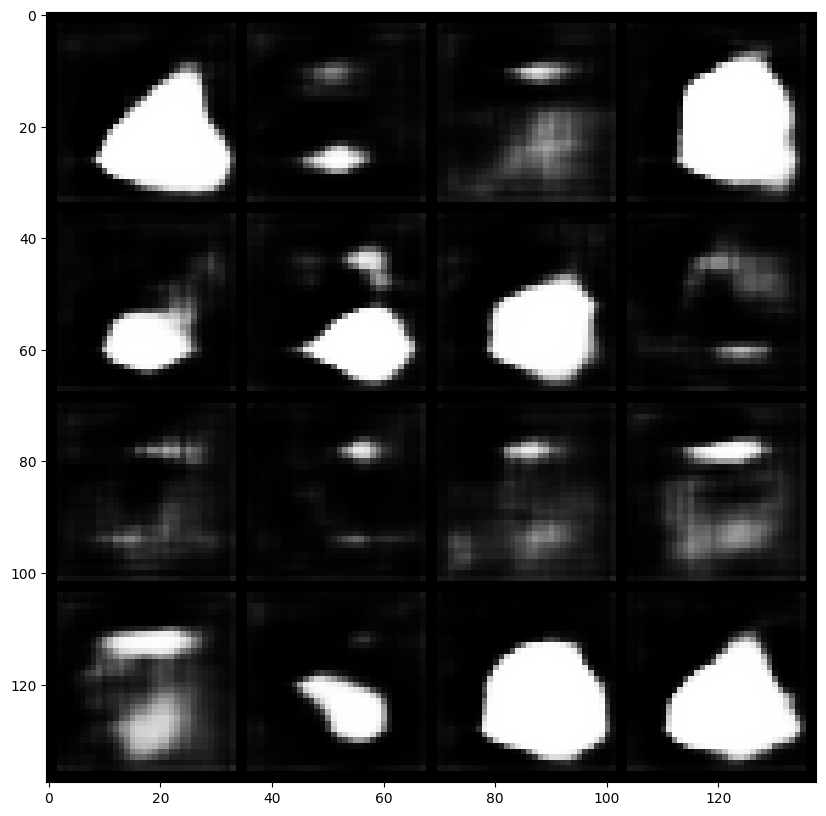

In [ ]:
test_fake = g_net(fixed_latent_noise)
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_fake.detach().cpu(), 4, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
imageio.mimsave('MNIST_GAN.gif', test_images_log)